# Natural Language Processing (NLP) - Classificação de Sentimentos

In [1]:
# Apaga todas as variáveis
%reset

In [ ]:
# Pacotes necessários (tirar o comentário para instalar)
# !pip install pandas
# !pip install matplotlib
# !pip install sklearn
# !pip install nltk
# !pip install lime
# !pip install seaborn
# !pip install matplotlib_venn

## Bibliotecas

In [1]:
# Bibliotecas básicas
import os
import sys
import string
from unicodedata import normalize
import time
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Processamento dos Dados
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD

In [3]:
# Exploração do dados
from sklearn import metrics
from sklearn.datasets import make_classification
from nltk import ngrams, FreqDist
from matplotlib_venn import venn2 

In [4]:
# Modelagem / Machine Learning
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

**********

## Preparando o ambiente

In [5]:
# O puknt dataset é necessários para realizar a tarefa de tokenização
nltk.download('punkt') 
# Instala a lista de stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/rflmorais/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rflmorais/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Define a pasta onde está o arquivo my_fuctions.py
sys.path.insert(0, './lib')
# exibir a plotagem diretamente abaixo da célula de código que o produziu
%matplotlib inline
# define o estilo a ser aplicado nas plotagens
sns.set_style('darkgrid')

In [7]:
# Pasta do projeto
folder_path = '../13_TCC/'
# Lista de datasets do projeto
print(f'Arquivos utilizados no projeto: \n{os.listdir(folder_path + "assets/")}\n')

Arquivos utilizados no projeto: 
['.DS_Store', 'fig', 'lgr_model.pkl', 'corpus_2021-01-07.csv', 'b2w-reviews01.csv', 'olist_order_reviews_dataset.csv']



## Funções Próprias

Funções criadas para serem utilizadas nas tarefas de processamento, análise exploratória, criação e avaliação dos modelos.

In [9]:
# Importa as funções do arquivo my_functions.py
import my_ml_functions as ml_tools

Módulo importado com sucesso em 16-01-2021 às 13:33:43


## Carregando o arquivo do Corpus

Antes de iniciar a Análise Exploratória dos Dados, vamos carregar o arquivo `corpus.csv`. Este arquivo contém o conjunto de dados já limpo e processado. Os procedimentos de normalização e processamento do dataset bruto foram realizados no arquivo `01_Coleta_e_Processamento.ipynb`

In [10]:
data = pd.read_csv(folder_path + 'assets/corpus_2021-01-07.csv')
#data.dropna(axis=0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155026 entries, 0 to 155025
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   processed_review  155026 non-null  object
 1   score             155026 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


***************

## Exploratory Data Analysis (EDA) - Análise Exploratória do Dados

Encerrada a etapa de normalização e processamento do texto. O dataset ficou com 2 colunas. A coluna `score` indica se o comentário foi positivo (1) ou negativo (0). Já a `processed_review` contém o texto da avaliação, processado e normalizado. Neste momento, será feita a análise exploratória dos dados para melhor conhecê-lo.

In [11]:
data.head()

,processed_review,score
0,recebi bem antes prazo estipulado,1
1,parabens adorei comprar internet seguro pratic...,1
2,recomendo aparelho eficiente site marca aparel...,1
3,pouco travando valor ta boa,1
4,super recomendo vendedor confiavel ok entrega ...,1


In [12]:
# ml_tools.make_latex(data.sample(10), file_name='processed_eda.tex',index=False, max_colwidth=False)

### Palavras mais imporatnates : Positivas *vs* Negativas

A seguir, será plotada as 30 palavras mais frequentes no texto de avaliação processado e normalizado com todas as etapas anteriores. Será plotado as 30 palavras mais imporatantes para a categoria positiva e para a categoria negativa

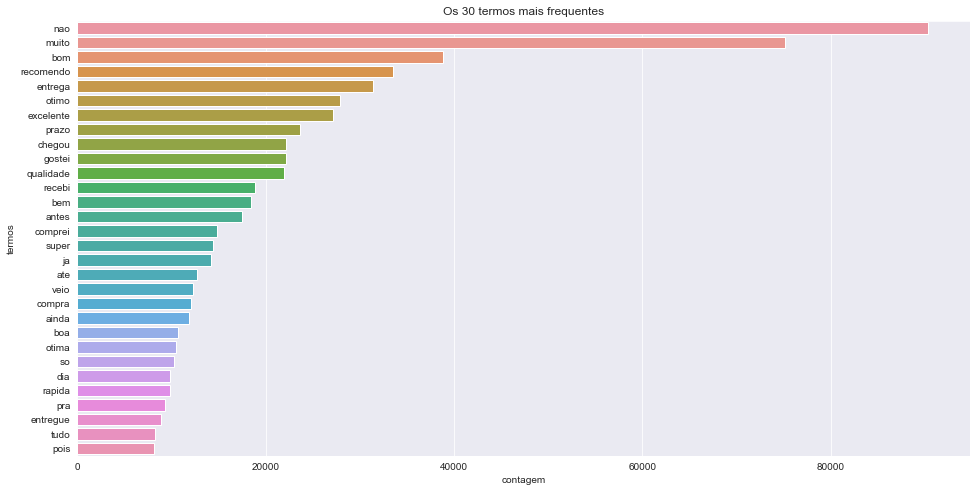

In [13]:
# Plota as top 30 plavras do corpus pode tirar, é so chamar de novo, plotndo
ml_tools.freq_words_df_or_plot(data['processed_review'])

In [14]:
# Filtra as palavras para cada polaridade
negativo = ml_tools.freq_words_df_or_plot(data['processed_review'][data['score'] == 0], plot=False, terms=20)
positivo = ml_tools.freq_words_df_or_plot(data['processed_review'][data['score'] == 1], plot=False, terms=20)

In [15]:
# Cria um dicionário com a frequeência para cada polaridade
freq_words_dict = {
    'Top 20 termos para Comentários Positivos': positivo,
    'Top 20 termos para Comentários Negativos': negativo
}

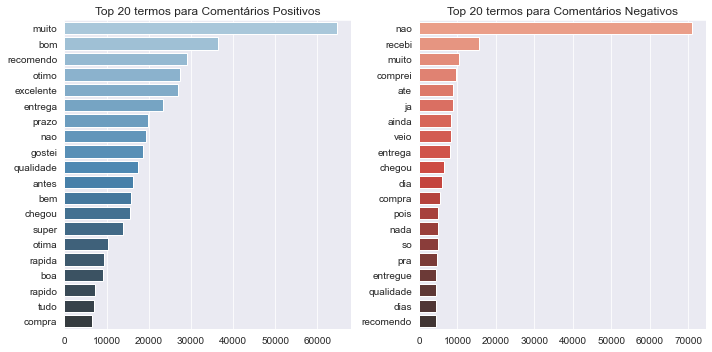

In [16]:
# Aplica a função no dicionário
ml_tools.plot_from_dict_freq_words(freq_words_dict)

In [17]:
# Identifica os termos que aparecem tanto para os comentários positivos quanto para os negativos
common_words = list(set(positivo['word'].tolist()).intersection(negativo['word'].tolist()))

In [18]:
print(f'As seguintes palavras aparecem em ambas as lista:\n {common_words}')

As seguintes palavras aparecem em ambas as lista:
 ['qualidade', 'chegou', 'recomendo', 'entrega', 'muito', 'nao', 'compra']


### Bag-of-Words

Dado o achado anterior, vamos aprofundar a análise das palavras do dataset. Para auxiliar neste procediemetno será utilizado a função CountVectorizer da biblioteca Scikit-learn.

Primeirmaente, vamos identificar quantas palvras possuem o dataset e quantas palavras aparecem tanto nas avaliações classficadas como negativas, quanto como positivas.

O atributo fit do CountVectorizer consiste na tokenização dos dados de treinamento e construção do vocabulário, que pode ser acessado como o atributo vocabulary_:

In [19]:
# Contagem de unigrams para cada polaridade
pos_unigrams = ml_tools.word_vec_ngrams_counter(data['processed_review'][data['score'] == 1], (1,1))
neg_unigrams = ml_tools.word_vec_ngrams_counter(data['processed_review'][data['score'] == 0], (1,1))

In [20]:
# ml_tools.make_latex(pos_unigrams.sort_values(by='count', ascending=False).head(5), 'pos_unigrams')
# ml_tools.make_latex(neg_unigrams.sort_values(by='count', ascending=False).head(5), 'neg_unigrams')

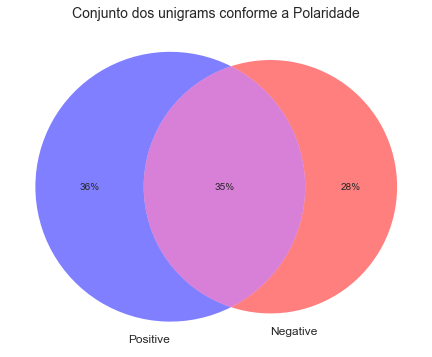

In [21]:
# Diagrama de Venn com as palavras do corpus
ml_tools.plot_venn(pos_unigrams['word'].tolist(), neg_unigrams['word'].tolist(), 'Conjunto dos unigrams conforme a Polaridade')

É possível notar que 37% das palavras são encontradas somente em comentários positivos, 28% da palavras em comentários negativos e 35% das palavras aparecem para ambas polaridades.
A seguir, será explorada outra alternativa (N-Grams) para segregar melhor as palavras que calssificam a avaliação como negativa ou postiva. O objetivo é reduzir o tamnho da interseção, que está em 35%.

### N-Grams

Uma das principais desvantagens de usar uma representação de bag-of-words (saco de palvras) é que a ordem das palavras é completamente descartada. Portanto, as duas cadeias de caracteres "é ruim, não é bom" e "é bom, não é ruim" têm exatamente a mesma representação em um bag-of-words, embora os significados sejam invertidos. Colocar “não” antes de uma palavra é apenas um exemplo (se for extremo) de como o contexto é importante. Felizmente, existe uma maneira de capturar o contexto ao usar uma representação de saco de palavras, considerando não apenas as contagens de tokens individuais, mas também a contagem de pares ou tripletos de tokens que aparecem um ao lado do outro. Pares de tokens são conhecidos como bigramas, tripletos de tokens são conhecidos como trigramas e, mais geralmente, sequências de tokens são conhecidas como n-gramas. 

Este intervalo de tokens pode ser facilmente alterado por meo do parâmetro "ngram_range" de CountVectorizer ou TfidfVectorizer. O parâmetro ngram_range é uma tupla, consistindo no comprimento mínimo e no comprimento máximo das sequências de tokens que são consideradas.

A função "word_vec_n_grams_counter", definida anteriormente, possui o parâmetro "n_grams" para definir quantos tokens formarão um conjunto. 

In [22]:
# Exemplo de corpus
texto = [
    'produto é muito bom. produto de qualidade',
    'péssimo produto, não é bom'
]

In [23]:
# Exemplo de unigram bag-of-words
vec = CountVectorizer(ngram_range=(1,1))
uni_features, uni_df = ml_tools.extract_features_from_corpus(texto, vec, df=True)
print(f'Tamanho do vocabulário: {uni_features.shape[1]}')
print(f'Número de documentos {uni_features.shape[0]}')
display(uni_df)

Tamanho do vocabulário: 7
Número de documentos 2


,bom,de,muito,não,produto,péssimo,qualidade
doc_1,1,1,1,0,2,0,1
doc_2,1,0,0,1,1,1,0


In [24]:
# Exemplo de bigram bag-of-words
vec = CountVectorizer(ngram_range=(2,2))
bi_features, bi_df = ml_tools.extract_features_from_corpus(texto, vec, df=True)
print(f'Tamanho do vocabulário: {bi_features.shape[1]}')
print(f'Número de documentos {bi_features.shape[0]}')
display(bi_df)

Tamanho do vocabulário: 8
Número de documentos 2


,bom produto,de qualidade,muito bom,não bom,produto de,produto muito,produto não,péssimo produto
doc_1,1,1,1,0,1,1,0,0
doc_2,0,0,0,1,0,0,1,1


In [26]:
# ml_tools.make_latex(uni_df, 'uni_df', index=True)
# ml_tools.make_latex(bi_df, 'bi_df', index=True)

#### Bigrams

In [27]:
# Utilza o CountVectorizer para gerar um saco de palavras com  todos os bigramas
bigrams = ml_tools.word_vec_ngrams_counter(data['processed_review'], (2,2))

In [28]:
# Os 20 bigramas mais frquentes
top_20_bigrams = bigrams.sort_values(by='count', ascending=False).head(20)

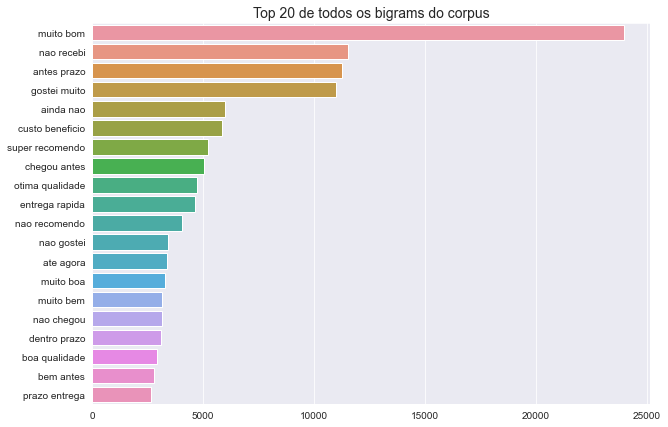

In [29]:
# Plota as top 20 bigrams do corpus
_ = plt.figure(figsize=(10,7))
_ = sns.barplot(data=top_20_bigrams, x= "count", y = "word")
_ = plt.title('Top 20 de todos os bigrams do corpus', size=14)
_ = plt.xlabel('')
_ = plt.ylabel('')
plt.show()

In [30]:
#Gera bigrams conforme a polaridade
pos_bigrams = ml_tools.word_vec_ngrams_counter(data['processed_review'][data['score'] == 1], (2,2))
neg_bigrams = ml_tools.word_vec_ngrams_counter(data['processed_review'][data['score'] == 0], (2,2))

In [31]:
top20_pos_bigrams = pos_bigrams.sort_values(by='count', ascending=False).head(30)
top20_neg_bigrams = neg_bigrams.sort_values(by='count', ascending=False).head(30)

In [32]:
# ml_tools.make_latex(top20_pos_bigrams.head(5), 'pos_bigrams')
# ml_tools.make_latex(top20_neg_bigrams.head(5), 'neg_bigrams')

In [33]:
# Cria um dicionário com a frequeência para cada polaridade
freq_bigrams_dict = {
    'Top 20 bigrams para Comentários Positivos': top20_pos_bigrams,
    'Top 20 bigrams para Comentários Negativos': top20_neg_bigrams
}

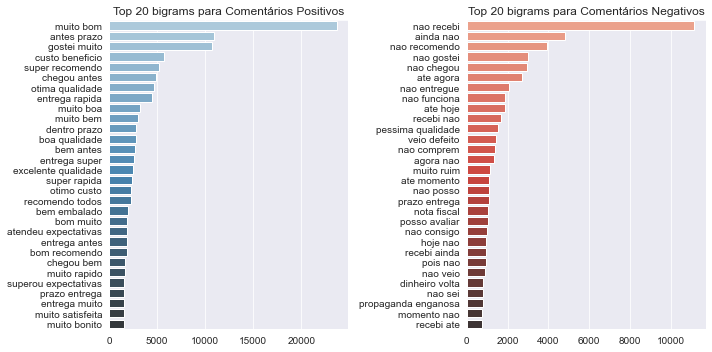

In [34]:
ml_tools.plot_from_dict_freq_words(freq_bigrams_dict)

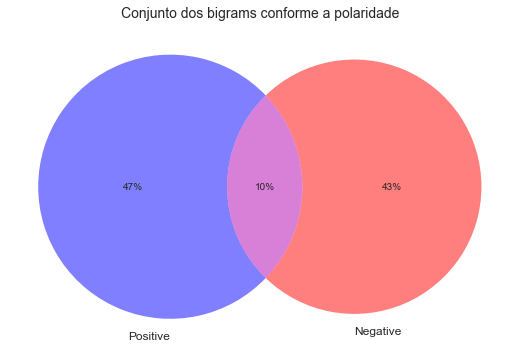

In [35]:
# Plota um diagrama de Venn
ml_tools.plot_venn(pos_bigrams['word'].tolist(), neg_bigrams['word'].tolist(), 'Conjunto dos bigrams conforme a polaridade')

Quando comparado ao bag-of-words tradicional (tokenização em unigrams), há uma sensível melhora na distribuição dos tokens que classificam os comentários como positivos ou negativos. Enquanto que no saco de palavras tradicional 35% das palavras classificavam o comentários para ambas as polaridades, no bag-of-words com bigrams apenas 10% das palavras classficam para ambas as polaridades.

### Desbalanceamento do Dataset (*Imbalanced Dataset*)

O desbalancemanto da classe ocorre quando  um dataset possui muitos exemplos de uma classe e poucos exemplos da outra classe. Nesta situação em um modelo de classificação, por exemplo, o resultado desse modelo poderá ser enviesado, ou seja pode tender a classificar os novos dados como sendo da classe que possui mais exemplos.

Portanto, vamos analisar se o aparente desbalancemanto do nosso dataset irá causar uma enviesamento na análise, ou seja, se haverá uma tendência a classificar a avaliação como positiva, já que esta categoria conta com quase 70% do registros.

Portanto, vamos começar apresentando um exemplo de dataset nitidamnte desbalanceado e na sequência vamos analisar a acurácia deste modelo desbalanceado, bem como sua matriz de confusão.


plotando novamente a quantidade de registros para cada classificação sobre o corpus processado e normalizado

### Toy Dataset de um exemplo desbalanceado

In [36]:
# Toy dataset para apresentar uma exemplo desbalanceado
corpus, y = make_classification(
    n_classes=2, 
    weights=[0.99, 0.01], 
    n_features=1, 
    n_informative=1,
    n_redundant=0,
    n_clusters_per_class=1,
    n_samples=10000,
    class_sep = 0.1,
    random_state=10
)
# Cria o dataframe
df = pd.DataFrame(corpus, columns=['corpus'])
df['target'] = y

In [37]:
df.groupby('target').count()

,corpus
target,
0,9842
1,158


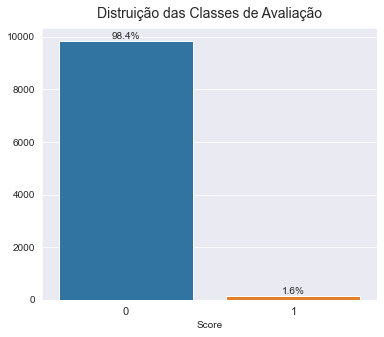

In [38]:
ml_tools.plot_target_count(df=df, target='target', figsize=(6,5))

A curva gaussianda mostra como os dados do Toy Dataset estão sobrepostos. Isso torna o desbalanceamento um problema ainda mais grave, uma vez que ficará ainda mais difícil para o modelo identificar as diferença entre as classes.

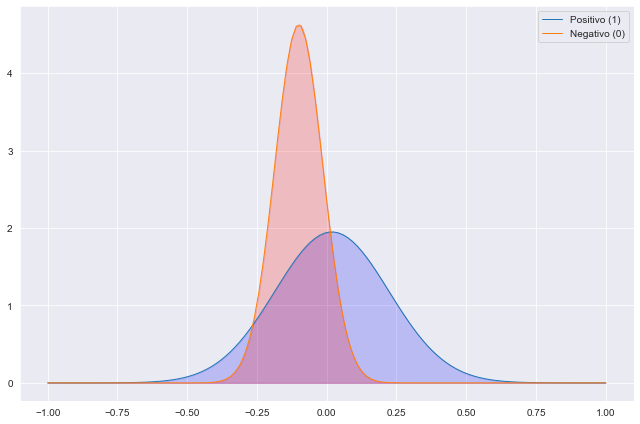

In [39]:
ml_tools.plot_gaussian(df, -1, 1)

In [40]:
X_toy = df[df.columns[:-1]]
y_toy = df['target']

In [41]:
toy_lgr = LogisticRegression()
toy_lgr.fit(X_toy, y_toy)
y_toy_pred = toy_lgr.predict(X_toy)
y_toy_pred_proba = toy_lgr.predict_proba(X_toy)[:,1]
print(f'Acurácia do Toy dataset: {metrics.accuracy_score(y_toy, y_toy_pred):.2%}')

Acurácia do Toy dataset: 98.46%


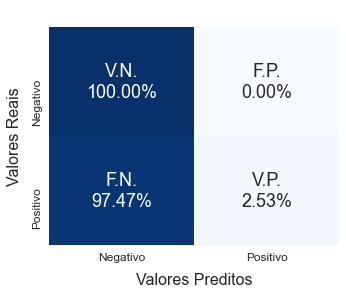

In [42]:
ml_tools.custom_cf_matrix(y_toy, y_toy_pred)

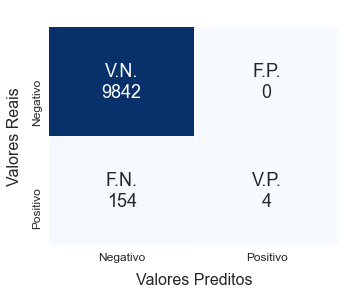

In [43]:
ml_tools.custom_cf_matrix(y_toy, y_toy_pred, normalize=None)

Acurácia = 98.46%



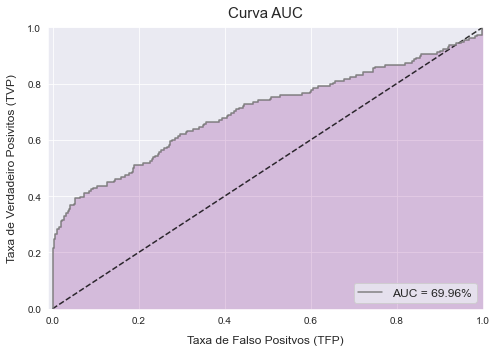

In [44]:
ml_tools.plot_auc(toy_lgr, X_toy, y_toy, y_toy_pred)

Resultado de um modelo desbalanceado. Apesar de uma acurácia altíssima, o modelo consegui prever somente 25% dos valores positios. Ou seja, classificou erroneamente o valores negativos em 75% das vezes.

### Dataset do problema proposto

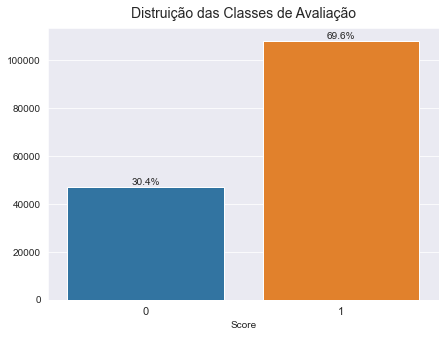

In [45]:
# Distribuição dos dados para do dataset do projeto
ml_tools.plot_target_count(data, 'score', (7,5))

### Undersampling

A subamostragem pode ser definida como a remoção de algumas observações da classe majoritária. Foi escolhida a subamostragem por ser um dataset com muitas linhas. Mas uma desvantagem é que se está removendo informações que podem ser valiosas. Isso pode levar a um ajuste insuficiente e a uma generalização insuficiente para o conjunto de teste. 

Portanto, será feita o Undersampling e será comparado com o dataset completo. Para a comparação será analisda a Matriz de Confusão, a Precisão, a Sensibilidade (Revocação) e  a Medida F (F1 Score), bem como a acurácia geral do modelo.

Será utilizado o Classificador de Regressão Logística (também conhecido como logit, MaxEnt) para as métricas.

In [46]:
# Divide por categoria
df_neg = data[data['score'] == 0]
df_pos = data[data['score'] == 1]

# reduzindo de forma aleátoria a categoria majoritária
neg_downsampled = resample(
    df_pos,
    replace = False, # sample without replacement
    n_samples = len(df_neg), # match minority n
    random_state = 27 # garante a reprodutividade
)
#combina a minoritária com a  downsampled majoritária
balanceado = pd.concat([neg_downsampled, df_neg]).reset_index(drop=True)
print('O dataset desbalanceado possui:')
print(f'{df_neg["score"].value_counts()[0]:,} classificações negativas;')
print(f'{df_pos["score"].value_counts()[1]:,} positivas.')
print(f'Após o undersamplig, há {balanceado["score"].value_counts()[0]:,} classificações para cada categoria')

O dataset desbalanceado possui:
47,099 classificações negativas;
107,927 positivas.
Após o undersamplig, há 47,099 classificações para cada categoria


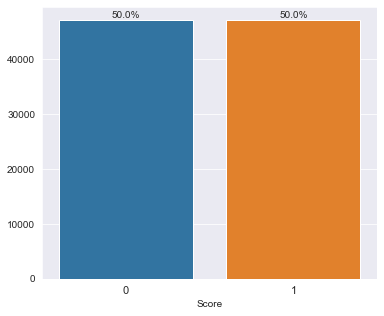

In [47]:
ml_tools.plot_target_count(balanceado, 'score', figsize=(6,5), title=False)

#### Comparando os Datasets Balanceado e Desbalanceado

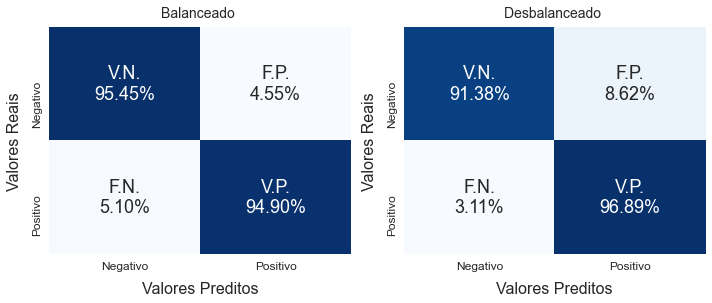

Relatório de Classificação do modelo com o Dataset Balanceado vs Desbalanceado:
         dataset acurácia precisão revocação f1_score
0     Balanceado   95.18%   95.42%    94.90%   95.16%
1  Desbalanceado   95.22%   96.26%    96.89%   96.58%


In [48]:
set_data = {'Balanceado': balanceado, 'Desbalanceado': data}
df_imabalanced_analysis = ml_tools.imbalanced_analysis(set_data)

### Curva Gaussiana

Antes de aplicar a função para plotar a Curva Gaussinana é preciso tranformar o corpus (que é um conjunto de string) em um vetor de números.

A classe CountVenctorizer do sklearn irá realizar esta tarefa. O CountVenctorizer criva uma nova coluna para cada palavra única, portanto, centenas de milhares de features foram criadas isso tornaria impossivel a visualização em um gráfico. Sendo assim, é preciso reduzir o número de dimensões, esta tarefa foi realizada com a classe TruncatedSVD. O vetor de features do corpus foi reduzido para 1 dimensão, para que seja possivel plotar a curva Gaussiana.

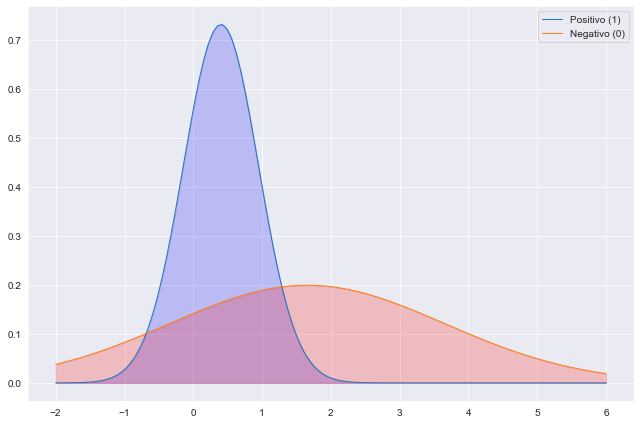

In [49]:
# Vetoriza o dataset balanceado  e reduz para uma dimensão
balanceado_svd = ml_tools.vectorize(balanceado)
# Plota a Curva Gaussiana
ml_tools.plot_gaussian(balanceado_svd, -2, 6)

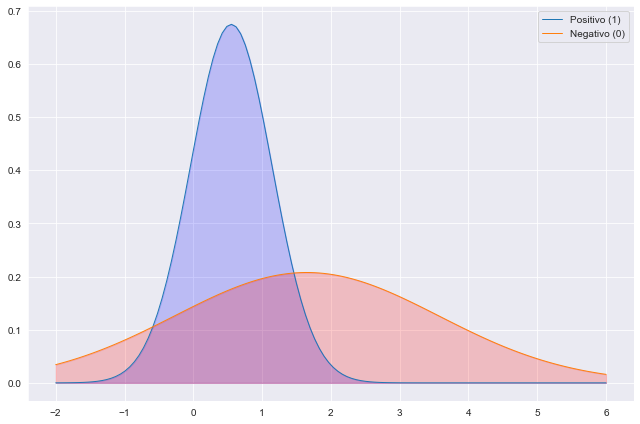

In [50]:
# Vetoriza o dataset original sem balanceamento e reduz para uma dimensão
data_svd = ml_tools.vectorize(data)
# Plota a Curva Gaussiana
ml_tools.plot_gaussian(data_svd, -2, 6)

In [51]:
data_svd

,features,target
0,0.273988,1
1,0.078628,1
2,0.257576,1
3,0.055820,1
4,0.305781,1
...,...,...
155021,1.999553,0
155022,2.064564,0
155023,1.758132,0
155024,1.016647,0


É possível notar que com o balanceamento houve uma ligeira melhora da predição dos valores negativos com uma consquente piora na predição dos valores positivos. Já de acordo com o Relatório de Classificação, no modelo balanceado, houve uma ligieira piora em todas as métricas.

Com o undersampling houve uma melhora na classficação da classe minoritária. Contudo, não ficou claro os benfefícios do umdersampling, portanto não será aplicado nenhuma técnina de pré-balanceamento (deixaremos para o algorítimo de machine learning lidar com isso), pois o dataset como está possui uma boa capacidade de predição. Desta forma, para a etapa seguinte (construção do modelo, será utilizado o dataset normalizado e processado conforme estapas anteriores, sem aplicar o balanceamento).

*********************************************************************************************************************************************************

## Fature Extraction

 Há diversas abordagens para realizar esta tarefa. Neste trabalho será abordado Bag of Words (CountVectorizer) e o TF-IDF. Para facilitar a análise, foi criada a função extract_features_from_corpus(...) que recebe um objeto de texto e um vetorizador e aplica a feature extraction no respectivo texto.

### CountVectorizer

Esta é uma forma de transformar um texto em vetor de frequência considerando a abordagem tradicional do Bag-of-Words em que há um descarte da maior parte da estrutura das frases e sentenças do texto de entrada. Há apenas a contagem da frequência com que cada palavra aparece em cada texto do corpus.

O método fit do CountVectorizer consiste na tokenização dos dados de treinamento e construção do vocabulário, que pode ser acessado com o atributo vocabulary_:

A criação do vetor que representa o bag-of-words é criado com a aplicação do método transform sobre o dado de treinamento.

In [52]:
data['processed_review'].head()

0                    recebi bem antes prazo estipulado
1    parabens adorei comprar internet seguro pratic...
2    recomendo aparelho eficiente site marca aparel...
3                          pouco travando valor ta boa
4    super recomendo vendedor confiavel ok entrega ...
Name: processed_review, dtype: object

In [53]:
# Cria um objeto da classe CountVectorizer
cv = CountVectorizer()

# Extrai as características do corpus
cv_features, df_cv_features = ml_tools.extract_features_from_corpus(data['processed_review'][:5], cv, df=True, n_cols=15)
print(f'Formato da matrix de vetores: {cv_features.shape}')
print(f'Portanto foi criado um vetor com {cv_features.shape[0]:,} registros e {cv_features.shape[1]:,} palavras.\n')
print(f'Exemplo do DataFrame coma as features do corpus:')
df_cv_features

Formato da matrix de vetores: (5, 37)
Portanto foi criado um vetor com 5 registros e 37 palavras.

Exemplo do DataFrame coma as features do corpus:


,adorei,antes,aparelho,atualizar,bem,boa,chegar,comprar,confiavel,correta,desinfector,eficiente,entrega,estipulado,feliz
doc_1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
doc_2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
doc_3,0,0,3,1,0,0,1,0,0,1,1,1,0,0,0
doc_4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
doc_5,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0


### TF-IDF
Como os vetores de recursos são baseados em frequências de termos absolutos, pode haver
alguns termos que ocorrem com frequência em todos os documentos e tendem a ofuscar outros
termos no conjunto de recursos. O modelo TF-IDF tenta combater esse problema usando um
fator de escala ou normalização em seu cálculo. TF-IDF significa Term Frequency-Inverse
Document Frequency, que usa uma combinação de duas métricas em seu cálculo, a saber:
frequência de termo (tf) e frequência de documento inversa (idf). Esta técnica foi
desenvolvida para classificar resultados de consultas em motores de busca e hoje é um
modelo indispensável no mundo da recuperação de informação e analítica de texto

In [54]:
# Cria um objeto da classe TfidfVectorizer
tfidf = TfidfVectorizer()

# Extrai as características do corpus
tfidf_features, df_tfidf_features = ml_tools.extract_features_from_corpus(data['processed_review'][:5], tfidf, df=True, n_cols=12)
print(f'Formato da matrix de vetores: {tfidf_features.shape}')
print(f'Portanto foi criado um vetor com {tfidf_features.shape[0]:,} registros e {tfidf_features.shape[1]:,} palavras.\n')
print(f'Exemplo do DataFrame coma as features do corpus:')
df_tfidf_features

Formato da matrix de vetores: (5, 37)
Portanto foi criado um vetor com 5 registros e 37 palavras.

Exemplo do DataFrame coma as features do corpus:


,adorei,antes,aparelho,atualizar,bem,boa,chegar,comprar,confiavel,correta,desinfector,eficiente
doc_1,0.000000,0.388988,0.000000,0.000000,0.48214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
doc_2,0.288675,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.288675,0.000000,0.000000,0.000000,0.000000
doc_3,0.000000,0.000000,0.616875,0.205625,0.00000,0.000000,0.205625,0.000000,0.000000,0.205625,0.205625,0.205625
doc_4,0.000000,0.000000,0.000000,0.000000,0.00000,0.447214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
doc_5,0.000000,0.305974,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.379247,0.000000,0.000000,0.000000


*************

Vamos agora aplicar a classe TfidfVectorizer sobre todo o conjunto de dados para conhecermos o tamanho do vocabulário (quantas palavras únicas) do nosso conjunto de dados.

In [55]:
tfidf = TfidfVectorizer()
tfidf_vec = tfidf.fit_transform(data['processed_review'])
print(f'Foi produzida uma matriz no formato {tfidf_vec.shape[0]:,} x {tfidf_vec.shape[1]:,}.')

Foi produzida uma matriz no formato 155,026 x 48,733.


In [56]:
ml_tools.success_message(2)

 

    Todos os trechos de código deste Jupyter Notebook foram executados com sucesso.
    A análise exploratória dos dados foi encerrada.
    Agora prossiga no Jupyter Notebook 03_Modelos_e_Metricas.ipynb para Modelagem e
    Avaliadção Modelo .
    
    


***********